# Основная программа

In [21]:
# !pip install pyts

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
from matplotlib import dates
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import (
    check_array, check_is_fitted, check_random_state)

%matplotlib inline
warnings.filterwarnings('ignore')

In [23]:
def whiteNoise(sigma=1, size=1):
    return np.random.normal(0, sigma, size)

def split_on_windows(X,len_w,len_k,step=1):
    if step>len_w:
        raise TypeError("Шаг должен быть меньше, либо равен размеру окна {} > {}".format(step,len_w))
    n = len(X)
    count_w_k = n-len_k-len_w+1
    split_data_windows = []
    split_data_future = []
    
    if type(X) == type(list()):
        X = np.array(X)
    
    if len(X.shape) == 1:
        X_copy = []
        for val in X:
            X_copy.append([val])
        X = np.array(X_copy)
    
    for i in range(0,count_w_k,step):
        split_data_windows.append(X[i:i+len_w])
        split_data_future.append(X[i+len_w:i+len_w+len_k])
        
    split_data_windows = np.array(split_data_windows)
    split_data_future = np.array(split_data_future)
    if len(split_data_windows.shape) == 2:
        return split_data_windows[:,0], split_data_future[:,0]
    elif len(split_data_windows.shape) == 3:
        return split_data_windows[:,:,0], split_data_future[:,:,0]

def get_coefs_linear_regression(values): 
    coefs = []
    size_future_window = len(values[0])

    X = np.array([[i+1] for i in range(size_future_window)])

    for i in range(len(values)):
        y = values[i]
        reg = LinearRegression().fit(X,y)
        coefs.append(reg.coef_)
    coefs = np.array(coefs)
    return coefs

def extract_mean_std_slope(X):
    '''
    This transformer extracts 3 features from each window: the mean, the
    standard deviation and the slope.
    '''
    n_windows = X.shape[0]
    X_new = np.empty((n_windows, 3))
    start = 0
    end = X.shape[1]
    arange = np.arange((start - end + 1) / 2, (end + 1 - start) / 2)
    if end - start == 1:
        var_arange = 1.
    else:
        var_arange = np.sum(arange ** 2)

    for i in range(n_windows):    
        mean = np.mean(X[i])
        X_new[i, 0] = mean
        X_new[i, 1] = np.std(X[i])
        X_new[i, 2] = (
            np.sum((X[i] - mean) * arange) / var_arange
        )
    return X_new

def extract_rocket(X,n_kernels=100,random_state=None):
    from pyts.transformation import ROCKET

    X_rocket = X
    rocket = ROCKET(n_kernels=n_kernels,random_state=random_state)
    rocket.fit(X_rocket)
    return rocket.transform(X)

In [24]:
class GetClasses(BaseEstimator):
    '''
    method: str (default = "growth")
        'growth':
        'type':
        (Описание).
    percent: int (default = 10)
        (Описание).
    random_state: int or None (default = None)
        (Описание).
    '''
    def __init__(self,
                 method='growth',
                 percent=20,
                 random_state=None
                ):
        self.percent = percent
        self.method = method
        self.random_state = random_state
        
    def count_classes(self, schema):
        count_first_classes = 0
        count_second_classes = 0
        count_third_classes = 0

        if schema == 'type':
            for val in self.coefs:
                if val > self.check_pos: count_first_classes += 1
                elif val < self.check_neg: count_third_classes += 1
                else: count_second_classes += 1
                    
        elif schema == 'growth':
            for val in self.coefs:
                if val >- 0:
                    if val > self.up_limit_pos: count_first_classes += 1
                    elif val < self.down_limit_pos : count_third_classes += 1
                    else: 
                        count_second_classes += 1
                else:
                    if val < self.up_limit_neg : count_first_classes += 1
                    elif val > self.down_limit_neg : count_third_classes += 1
                    else: 
                        count_second_classes += 1
        return count_first_classes, count_second_classes, count_third_classes
    
    def optimize_param(self, schema):
        f_c, s_c, c_c = self.count_classes(schema)
        
        max_classes = max(f_c, s_c, c_c)
        min_classes = min(f_c, s_c, c_c)
        
        while max_classes/min_classes > 1.25:
            if schema == 'type':
                if f_c == max_classes:
                    self.check_pos *= 1.1
                    if s_c == min_classes:
                        self.check_neg *= 1.1
                    elif c_c == min_classes:
                        self.check_neg *= 0.9
                elif c_c == max_classes:
                    self.check_neg *= 1.1
                    if s_c == min_classes:
                        self.check_pos *= 1.1
                    elif f_c == min_classes:
                        self.check_pos *= 0.9
                else:
                    self.check_pos *= 0.9
                    self.check_neg *= 0.9
                    
            if schema == 'growth':
                if f_c == max_classes:
                    self.up_limit_pos *= 1.1
                    self.up_limit_neg *= 1.1
                    if s_c == min_classes:
                        self.down_limit_pos *= 0.9
                        self.down_limit_neg *= 0.9
                    elif c_c == min_classes:
                        self.down_limit_pos *= 1.1
                        self.down_limit_neg *= 1.1
                elif c_c == max_classes:
                    self.down_limit_pos *= 0.9
                    self.down_limit_neg *= 0.9
                    if s_c == min_classes:
                        self.up_limit_pos *= 1.1
                        self.up_limit_neg *= 1.1
                    elif f_c == min_classes:
                        self.up_limit_pos *= 0.9
                        self.up_limit_neg *= 0.9
                else:
                    self.up_limit_pos *= 0.9
                    self.down_limit_pos *= 1.1
                    self.down_limit_neg *= 1.1
                    self.up_limit_neg *= 0.9
                    
            f_c, s_c, c_c = self.count_classes(schema)
        
            max_classes = max(f_c, s_c, c_c)
            min_classes = min(f_c, s_c, c_c)
            
        return self
    
    def get_parameters(self):
        self.coefs_pos = self.coefs[np.where(self.coefs>=0)]
        self.coefs_neg = self.coefs[np.where(self.coefs<0)]
        
        self.check_pos = np.max(self.coefs_pos) / 100 * self.percent
        self.check_neg = np.min(self.coefs_neg) / 100 * self.percent

        # обработка положительного тренда
        self.max_coef_pos = np.max(self.coefs_pos)
        self.min_coef_pos = np.min(self.coefs_pos)
        self.distance_pos = (self.max_coef_pos + self.min_coef_pos)
        self.middle_pos = self.distance_pos / 2
        self.up_limit_pos = self.distance_pos / 100 * (50 + self.percent/2) # верхняя граница, больше относительно середины на (percent/2)%
        self.down_limit_pos = self.distance_pos / 100 * (50 - self.percent/2) # нижняя граница, меньше относительно середины на (percent/2)%

        # обработка отрицательного тренда
        self.max_coef_neg = np.max(self.coefs_neg)
        self.min_coef_neg = np.min(self.coefs_neg)
        self.distance_neg = (self.max_coef_neg + self.min_coef_neg)
        self.middle_neg = self.distance_neg / 2
        self.up_limit_neg = self.distance_neg / 100 * (50 + self.percent/2) # верхняя граница, больше относительно середины на (percent/2)%
        self.down_limit_neg = self.distance_neg / 100 * (50 - self.percent/2) # нижняя граница, меньше относительно середины на (percent/2)%
        
        self.optimize_param(self.method)
        
        return self
    
    def get_classes_type(self): 
        '''
        класс "1" - положительный тренд
        класс "0" - тренд отсутствует
        класс "-1" - отрицательный тренд
        '''
        
        classes = []
        for val in self.coefs:
            if val > self.check_pos : classes.append(1)
            elif val < self.check_neg : classes.append(-1)
            else: 
                classes.append(0)
        classes = np.array(classes)
        return classes
    
    def get_classes_growth(self):
        '''
        proc - количество элементов в процентах, относящихся к классу "0"
        класс "1" - сильный рост тренда
        класс "0" - средний рост тренда
        класс "-1" - слабый рост тренда
        '''
        
        classes = []
        for val in self.coefs:
            if val >= 0:
                if val > self.up_limit_pos : classes.append(1)
                elif val < self.down_limit_pos : classes.append(-1)
                else: 
                    classes.append(0)
            else:
                if val < self.up_limit_neg : classes.append(1)
                elif val > self.down_limit_neg : classes.append(-1)
                else: 
                    classes.append(0)
        classes = np.array(classes)
        return classes
    
    def get_classes(self, X_train, X_test):
        size = X_train.shape[0]
        size_window = X_train.shape[1]
        
        self.coefs = get_coefs_linear_regression(X_train)
        
        self.get_parameters() # запоминаем характеристики коэффициентов
        
        self.coefs = np.concatenate([self.coefs,get_coefs_linear_regression(X_test)])
        
        if self.method == 'type':
            self.classes = self.get_classes_type() # тип тренда
        elif self.method == 'growth':
            self.classes = self.get_classes_growth() # скорость роста тренда
        return self.classes
    
    def plot(self):       
        coefs_first = self.coefs[np.where(self.classes==1)]
        coefs_second = self.coefs[np.where(self.classes==0)]
        coefs_third = self.coefs[np.where(self.classes==-1)]

        indexes_first = []
        indexes_second = []
        indexes_third = []

        for i in range(len(self.classes)):
            if self.classes[i] == 1:
                indexes_first.append(i+1)
            elif self.classes[i] == 0:
                indexes_second.append(i+1)
            else:
                indexes_third.append(i+1)

        plt.figure(figsize=(16,10))
        plt.scatter(indexes_first,coefs_first, c='g',label='Класс "1"')
        plt.scatter(indexes_second,coefs_second, c='y',label='Класс "0"')
        plt.scatter(indexes_third,coefs_third, c='r',label='Класс "-1"')

        if self.method == 'growth':
            plt.plot([0,len(self.classes)],[self.up_limit_pos,self.up_limit_pos],c='g')
            plt.plot([0,len(self.classes)],[self.down_limit_pos,self.down_limit_pos],c='r')
            plt.plot([0,len(self.classes)],[self.up_limit_neg,self.up_limit_neg],c='g')
            plt.plot([0,len(self.classes)],[self.down_limit_neg,self.down_limit_neg],c='r')
            plt.plot([0,len(self.classes)],[0,0],c='black', label='Граница')
        elif self.method == 'type':
            plt.plot([0,len(self.classes)],[self.check_pos,self.check_pos],c='g')
            plt.plot([0,len(self.classes)],[self.check_neg,self.check_neg],c='r')

        
        #plt.title('Разделение на классы коэффициентов регрессии')
        plt.xlabel('Номер окна')
        plt.ylabel('Коэффициент регрессии')
        plt.legend()
        plt.show()
    
    def plot_coefs(self):
        array = np.array([0,5])
        
        plt.figure(figsize=(16,10))
        
        plt.plot(1,0,c='r',label='Класс "-1"')
        plt.plot(1,0,c='y',label='Класс "0"')
        plt.plot(1,0,c='g',label='Класс "1"')
        
        for i in range(len(self.coefs)):
            if  self.classes[i] == -1:
                plt.plot(array,array*self.coefs[i],c='r')
            elif  self.classes[i] == 0:
                plt.plot(array,array*self.coefs[i],c='y')
            else:
                plt.plot(array,array*self.coefs[i],c='g')
        #plt.title('Разделение на классы коэффициентов регрессии')
        plt.xlabel('Значение')
        plt.ylabel('Наклон')
        plt.legend()
        plt.show()
        
    

In [25]:
class WindowFeatureExtractor(BaseEstimator):
    '''
    features: str (default = "mean_std_slope")
        'mean_std_slope':
        'rocket':
        (Описание).
    random_state: int or None (default = None)
        (Описание).
    '''
    def __init__(self,
                 features='mean_std_slope',
                 n_kernels=100,
                 random_state=None,
                ):
        self.features = features
        self.n_kernels = n_kernels
        self.random_state = random_state

    def _check_params(self):
        if not self.features in ('mean_std_slope','rocket', None):
            raise ValueError(" Метод {} отсутствует.".format(self.features))
        
    def transform(self,X):
        self._check_params()
        X = check_array(X, dtype='float64')
        
        if self.features == 'mean_std_slope':
            return extract_mean_std_slope(X)
        elif self.features == 'rocket':
            return extract_rocket(X,n_kernels=self.n_kernels,random_state=self.random_state)
        elif self.features is None:
            return X
        

In [26]:
class TrendClassification(BaseEstimator):
    '''
    size_window: int (default = 10)
        (Описание).
    size_future_window: int (default = 10)
        (Описание).
    step: int (default = 1)
        (Описание).
    criterion: str (default = "entropy")
        (Описание).
    features: str (default = "mean_std_slope")
        'mean_std_slope':
        'rocket':
        None:
        (Описание).
    percent: int (default = 10)
        (Описание).
    random_state: int or None (default = None)
        (Описание).
    '''
    def __init__(self,
                 n_estimators=100, # построение леса
                 criterion="entropy",
                 max_depth=4,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.,
                 max_features="auto",
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 bootstrap=True,
                 oob_score=False,
                 n_jobs=None,
                 verbose=0,
                 class_weight=None,
                 ccp_alpha=0.0,
                 max_samples=None,
                 features='mean_std_slope', # получение признаков
                 n_kernels=100,
                 random_state=None,
                ):
        # построение леса
        self.n_estimators = n_estimators               
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.bootstrap = bootstrap
        self.oob_score = oob_score
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.class_weight = class_weight
        self.ccp_alpha = ccp_alpha
        self.max_samples = max_samples
        # получение признаков
        self.features = features   
        self.n_kernels = n_kernels
        self.random_state = random_state
        
        
    def fit(self,X,y):
        # Получение признаков
        feature_extractor = WindowFeatureExtractor(
            features=self.features,
            n_kernels=self.n_kernels,
            random_state=self.random_state
        )
        X_features = feature_extractor.transform(X)
        
        # Обучение леса
        self.rfc = RandomForestClassifier(
            n_estimators=self.n_estimators,
            criterion=self.criterion,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            min_weight_fraction_leaf=self.min_weight_fraction_leaf,
            max_features=self.max_features,
            max_leaf_nodes=self.max_leaf_nodes,
            min_impurity_decrease=self.min_impurity_decrease,
            bootstrap=self.bootstrap,
            oob_score=self.oob_score,
            n_jobs=self.n_jobs,
            random_state=self.random_state,
            verbose=self.verbose,
            class_weight=self.class_weight,
            ccp_alpha=self.ccp_alpha,
            max_samples=self.max_samples,
            warm_start=False
        )
        self.rfc.fit(X_features,y)

        # Получение атрибутов
        self.base_estimator_ = self.rfc.base_estimator_
        self.classes_ = self.rfc.classes_
        self.estimators_ = self.rfc.estimators_
        self.feature_importances_ = self.rfc.feature_importances_
        self.n_features_in_ = (
            self.rfc.n_features_in_
            if hasattr(self.rfc, 'n_features_in_')
            else self.rfc.n_features_
        )
        self.oob_decision_function_ = getattr(
           self.rfc, 'oob_decision_function_', None)
        self.oob_score_ = getattr(self.rfc, 'oob_score_', None)

        return self
        
    
    def predict(self,X):
        check_is_fitted(self)
        
        feature_extractor = WindowFeatureExtractor(
            features=self.features,
            n_kernels=self.n_kernels,
            random_state=self.random_state
        )
        X_features = feature_extractor.transform(X)
        
        return self.rfc.predict(X_features)
    
    def predict_proba(self,X):
        check_is_fitted(self)
        
        feature_extractor = WindowFeatureExtractor(
            features=self.features,
            n_kernels=self.n_kernels,
            random_state=self.random_state
        )
        X_features = feature_extractor.transform(X)
        
        return self.rfc.predict_proba(X_features)
    
    def score(self,X,y):
        check_is_fitted(self)
        
        feature_extractor = WindowFeatureExtractor(
            features=self.features,
            n_kernels=self.n_kernels,
            random_state=self.random_state
        )
        X_features = feature_extractor.transform(X)
        
        return self.rfc.score(X_features, y)

## Примеры

### Искусственные данные

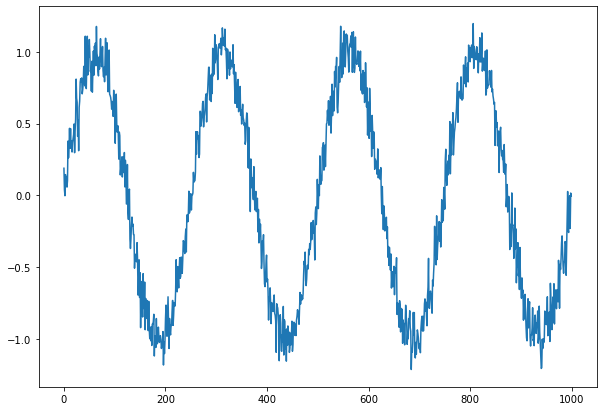

In [13]:
# деление на окна происходит до вызова TrendClassification
n = 1000
p = 4
seq = np.sin(np.linspace(-p*np.pi,p*np.pi,n)) + whiteNoise(sigma=0.1,size=n)

plt.figure(figsize=(10,7))
plt.plot(seq)

In [14]:
seq_main = seq
seq_main_df = pd.DataFrame(seq_main, columns=['value'])

# Разбиваем на окна
step = 1
len_w = 15 # размер окна предсказываемого набора
len_w_future = 15 # размер окна набора, на котором предсказывается

windows, windows_future = split_on_windows(seq_main_df,len_w,len_w_future,step=step)
windows_future_train, windows_future_test = train_test_split(windows_future, test_size=0.33, shuffle=False) 

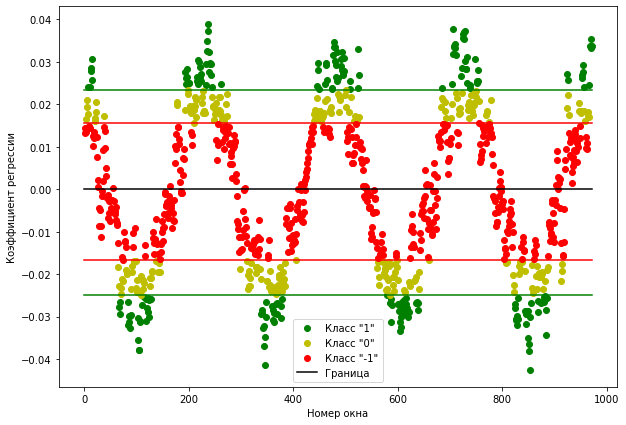

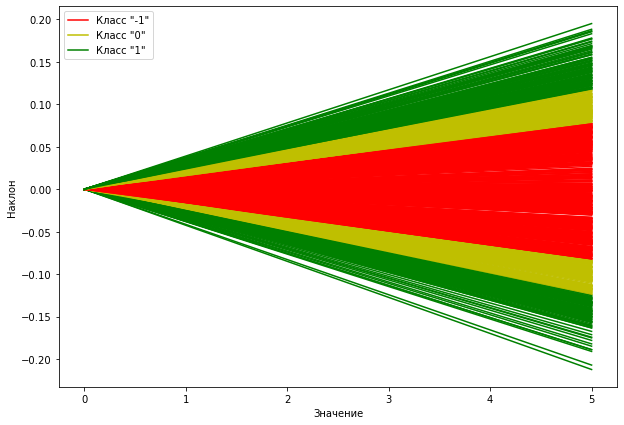

In [15]:
# Получаем классы
gc = GetClasses(method='growth')
gc_classes = gc.get_classes(windows_future_train, windows_future_test)
gc.plot()

gc.plot_coefs()

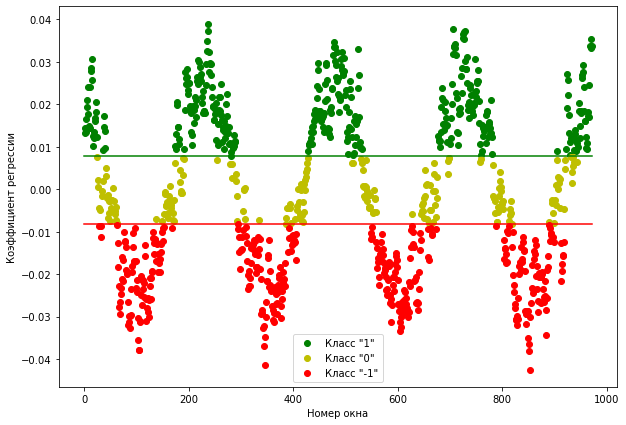

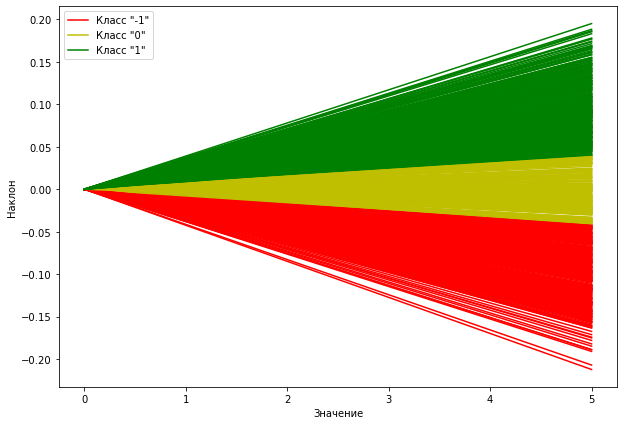

In [16]:
tc = GetClasses(method='type')
tc_classes = tc.get_classes(windows_future_train, windows_future_test)
tc.plot()
tc.plot_coefs()

In [ ]:
random_state = 42
features_mss = 'mean_std_slope'
features_rocket = 'rocket'
max_depth = 3

In [39]:
# Разбиение на обучающую и тренировочную выборку
gc_X_train, gc_X_test, gc_y_train, gc_y_test = train_test_split(windows, gc_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification (mean_std_slope)
gc_mss = TrendClassification(max_depth=max_depth,features=features_mss,random_state=random_state)
gc_mss.fit(gc_X_train,gc_y_train)
print('Trend Classification (features=mean_std_slope,method=growth)',gc_mss.score(gc_X_test,gc_y_test))

# Trend Classification (rocket)
gc_rocket = TrendClassification(max_depth=max_depth,features=features_rocket,random_state=random_state)
gc_rocket.fit(gc_X_train,gc_y_train)
print('Trend Classification (features=rocket,method=growth)',gc_rocket.score(gc_X_test,gc_y_test))


Trend Classification (features=mean_std_slope,method=growth) 0.5171339563862928
Trend Classification (features=rocket,method=growth) 0.5202492211838006


In [40]:
# Разбиение на обучающую и тренировочную выборку
tc_X_train, tc_X_test, tc_y_train, tc_y_test = train_test_split(windows, tc_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification (mean_std_slope)
tc_mss = TrendClassification(max_depth=max_depth,features=features_mss,random_state=random_state)
tc_mss.fit(tc_X_train,tc_y_train)
print('Trend Classification (features=mean_std_slope,method=type)',tc_mss.score(tc_X_test,tc_y_test))

# Trend Classification (rocket)
tc_rocket = TrendClassification(max_depth=max_depth,features=features_rocket,random_state=random_state)
tc_rocket.fit(tc_X_train,tc_y_train)
print('Trend Classification (features=rocket,method=type)',tc_rocket.score(tc_X_test,tc_y_test))



Trend Classification (features=mean_std_slope,method=type) 0.3894080996884735
Trend Classification (features=rocket,method=type) 0.37694704049844235


### Реальные данные

In [72]:
yahoo_stock = pd.read_csv('datasets\Time Series Forecasting with Yahoo Stock Price\yahoo_stock.csv')
yahoo_stock['Date'] = pd.to_datetime(yahoo_stock['Date'])
yahoo_stock.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [73]:
yahoo_stock_high = yahoo_stock[['Date','High']]
yahoo_stock_high.head()

,Date,High
0,2015-11-23,2095.610107
1,2015-11-24,2094.120117
2,2015-11-25,2093.000000
3,2015-11-26,2093.000000
4,2015-11-27,2093.290039


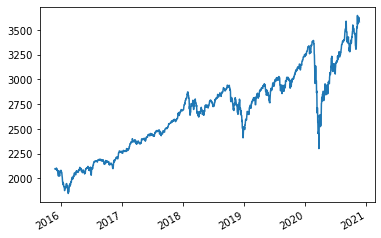

In [74]:
plt.plot(yahoo_stock_high['Date'], yahoo_stock_high['High'])
plt.gcf().autofmt_xdate()

In [75]:
high = yahoo_stock_high['High']

In [76]:
# Разбиваем на окна
step = 1
len_w = 15 # размер окна предсказываемого набора
len_w_future = 15 # размер окна набора, на котором предсказывается

high_windows, high_windows_future = split_on_windows(high,len_w,len_w_future,step=step)

In [77]:
high_windows_future_train, high_windows_future_test = train_test_split(high_windows_future, test_size=0.33, shuffle=False) 

In [79]:
# Получаем классы
high_gc = GetClasses(method='growth')
high_gc_classes = high_gc.get_classes(high_windows_future_train, high_windows_future_test)

high_tc = GetClasses(method='type')
high_tc_classes = high_tc.get_classes(high_windows_future_train, high_windows_future_test)

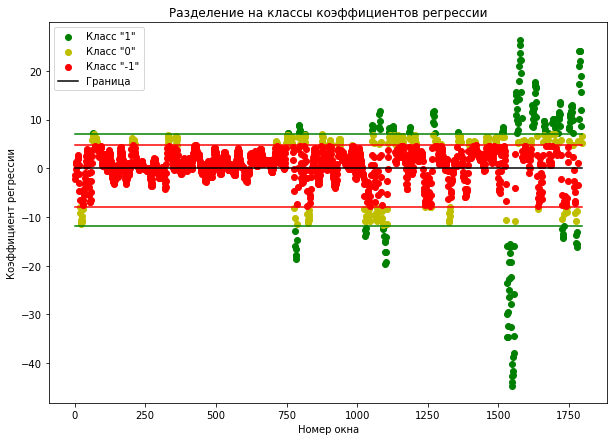

In [80]:
high_gc.plot()

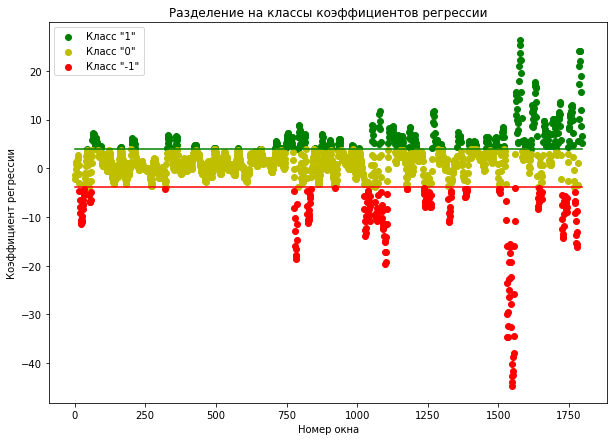

In [81]:
high_tc.plot()

In [82]:
# Устанавливаем параметры
random_state = 42
features_mss = 'mean_std_slope'
features_rocket = 'rocket'
max_depth = 3

In [83]:
# Разбиение на обучающую и тренировочную выборку
X_train, X_test, y_train, y_test = train_test_split(high_windows, high_gc_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification (mean_std_slope)
high_gc_mss = TrendClassification(max_depth=max_depth,features=features_mss,random_state=random_state)
high_gc_mss.fit(X_train,y_train)
print('Trend Classification (features=mean_std_slope,method=growth)',high_gc_mss.score(X_test,y_test))

# Trend Classification (rocket)
high_gc_rocket = TrendClassification(max_depth=max_depth,features=features_rocket,random_state=random_state)
high_gc_rocket.fit(X_train,y_train)
print('Trend Classification (features=rocket,method=growth)',high_gc_rocket.score(X_test,y_test))


Trend Classification (features=mean_std_slope,method=growth) 0.5564924114671164
Trend Classification (features=rocket,method=growth) 0.5666104553119731


In [84]:
# Разбиение на обучающую и тренировочную выборку
X_train, X_test, y_train, y_test = train_test_split(high_windows, high_tc_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification (mean_std_slope)
high_tc_mss = TrendClassification(max_depth=max_depth,features=features_mss,random_state=random_state)
high_tc_mss.fit(X_train,y_train)
print('Trend Classification (features=mean_std_slope,method=type)',high_tc_mss.score(X_test,y_test))

# Trend Classification (rocket)
high_tc_rocket = TrendClassification(max_depth=max_depth,features=features_rocket,random_state=random_state)
high_tc_rocket.fit(X_train,y_train)
print('Trend Classification (features=rocket,method=type)',high_tc_rocket.score(X_test,y_test))



Trend Classification (features=mean_std_slope,method=type) 0.4300168634064081
Trend Classification (features=rocket,method=type) 0.3608768971332209


## Сравнение методов классификации

In [27]:
# Сравнение с другими методами классификации
from sklearn import svm # Support Vector Machines
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent - Стохастичяеский градиентный спуск
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bayes
from sklearn.neural_network import MLPClassifier # Neural network models
from pyts.classification import TimeSeriesForest # Time Series Forest
from pyts.classification import TSBF # Time Series Bag-of-Features

In [28]:
def get_scores_models(X_train,X_test,y_train,y_test,method):
    scores = []
    
    if method in ('mean_std_slope', 'rocket'):
        scores.append(None)
        scores.append(None)
    else:
        # TimeSeriesForest
        tsf = TimeSeriesForest()
        tsf.fit(X_train,y_train)
        scores.append(tsf.score(X_test,y_test))

        # Time Series Bag-of-Features
        tsbf = TSBF(random_state=43, bins=5)
        tsbf.fit(X_train,y_train)
        scores.append(tsbf.score(X_test,y_test))

    # Support Vector Machines(rbf)
    svc = svm.SVC(kernel='rbf')
    svc.fit(X_train, y_train)
    scores.append(svc.score(X_test,y_test))
    
    # Support Vector Machines(linear)
    svc = svm.SVC(kernel='linear')
    svc.fit(X_train, y_train)
    scores.append(svc.score(X_test,y_test))
    
    # Support Vector Machines(poly)
    svc = svm.SVC(kernel='poly')
    svc.fit(X_train, y_train)
    scores.append(svc.score(X_test,y_test))

    # Stochastic Gradient Descent(log_loss)
    sgdc = SGDClassifier(loss="log", penalty="l2", max_iter=5)
    sgdc.fit(X_train, y_train)
    scores.append(sgdc.score(X_test,y_test))
    
    # Stochastic Gradient Descent(squared_hinge)
    sgdc = SGDClassifier(loss="squared_hinge", penalty="l2", max_iter=5)
    sgdc.fit(X_train, y_train)
    scores.append(sgdc.score(X_test,y_test))

    return scores

def get_scores(X,y,method,**kwargs):
    score = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False, random_state=kwargs['random_state'])
    
    # Trend Classification 
    tc = TrendClassification(features=method,random_state=kwargs['random_state'])
    tc.fit(X_train,y_train)
    score.append(tc.score(X_test,y_test))
    
    if method == 'mean_std_slope':
        X = extract_mean_std_slope(X)
    elif method == 'rocket':
        X = extract_rocket(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False, random_state=kwargs['random_state'])
    
    # Другие модели
    score += get_scores_models(X_train, X_test, y_train, y_test,method)
    return score

In [29]:
# Устанавливаем параметры
random_state = 42
features_none = None
features_mss = 'mean_std_slope'
features_rocket = 'rocket'
max_depth = 3

### Искусственный простой набор


In [30]:
# деление на окна происходит до вызова TrendClassification
n = 1000
p = 4
test_synthetic = np.sin(np.linspace(-p*np.pi,p*np.pi,n)) + whiteNoise(sigma=0.1,size=n)

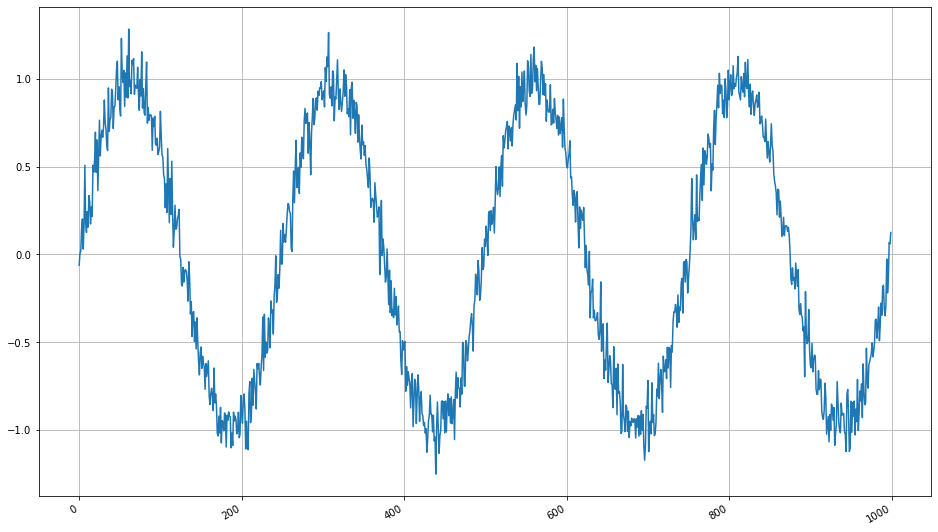

In [31]:
plt.figure(figsize=(16,10))
plt.plot(test_synthetic)
plt.gcf().autofmt_xdate()
plt.grid()

In [32]:
# Разбиваем на окна
step = 1
len_w = 15 # размер окна предсказываемого набора
len_w_future = 15 # размер окна набора, на котором предсказывается

windows_synthetic, windows_future_synthetic = split_on_windows(test_synthetic,len_w,len_w_future,step=step)

windows_future_synthetic_train, windows_future_synthetic_test = train_test_split(windows_future_synthetic, test_size=0.33, shuffle=False) 

In [36]:
# Получаем классы
gc_synthetic = GetClasses(method='growth')
gc_synthetic_classes = gc_synthetic.get_classes(windows_future_synthetic_train, windows_future_synthetic_test)

tc_synthetic = GetClasses(method='type')
tc_synthetic_classes = tc_synthetic.get_classes(windows_future_synthetic_train, windows_future_synthetic_test)

scores_synthetic = pd.DataFrame(['Trend Classification',
                                 'Time Series Forest',
                                 'Time Series Bag-of-Features',
                                 'Support Vector Machines (rbf)',
                                 'Support Vector Machines (linear)',
                                 'Support Vector Machines (poly)',         
                                 'Stochastic Gradient Descent (log_loss)',
                                 'Stochastic Gradient Descent (squared_hinge)'
                                ],
                                columns=['Классификатор'])

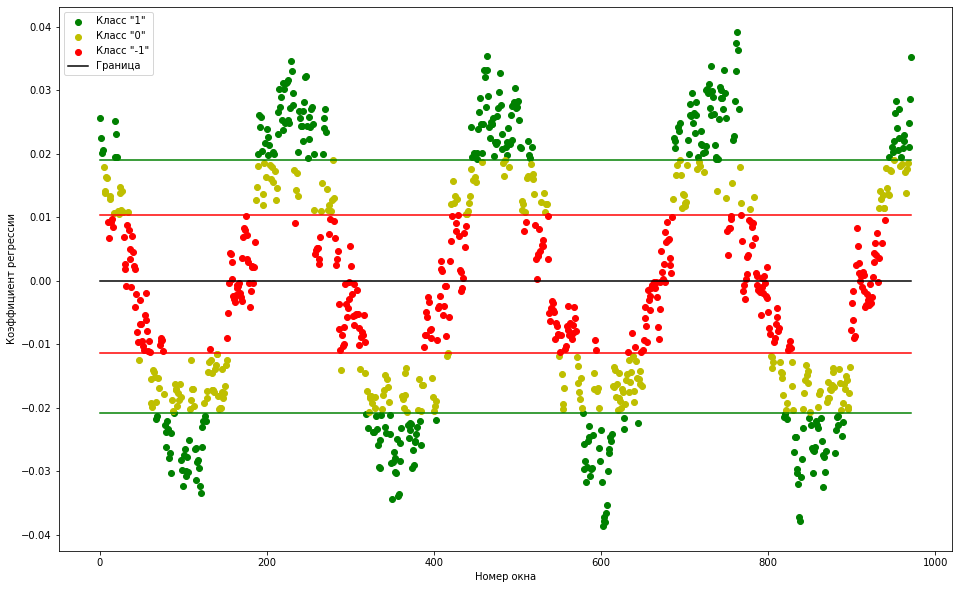

In [96]:
gc_synthetic.plot()

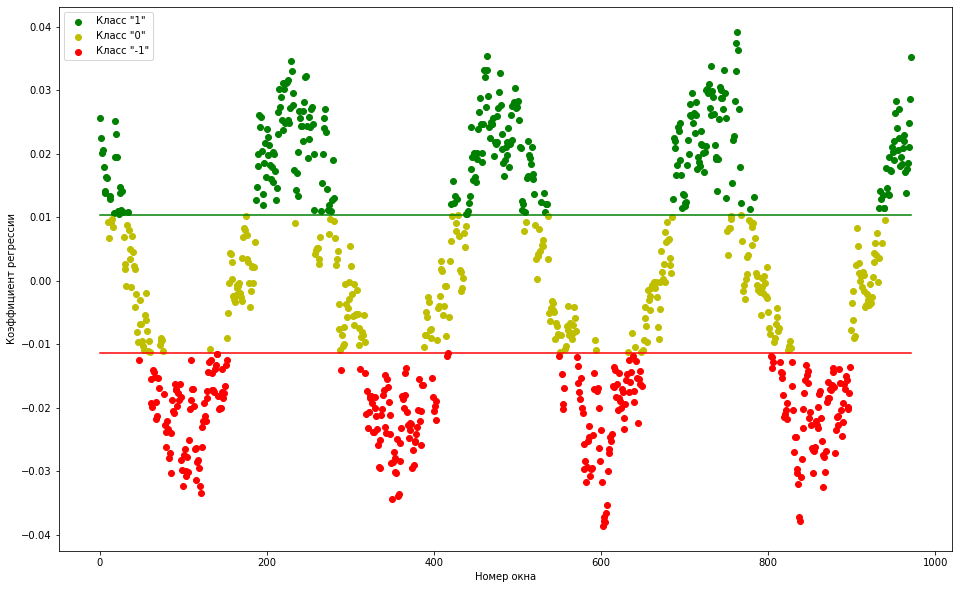

In [97]:
tc_synthetic.plot()

#### Метод разделения growth

In [37]:
# Грубая выборка
scores_synthetic['Грубые признаки (степень изменения)'] = get_scores(windows_synthetic,gc_synthetic_classes,method=None,random_state=random_state)

# Среднее значение, стандартное отклонение, наклон выборка
scores_synthetic['Признаки среднее, отклонение, наклон (степень изменения)'] = get_scores(windows_synthetic,gc_synthetic_classes,method='mean_std_slope',random_state=random_state)

# ROCKET выборка
scores_synthetic['Признаки ROCKET (степень изменения)'] = get_scores(windows_synthetic,gc_synthetic_classes,method='rocket',random_state=random_state)

#### Метод разделения type

In [38]:
# Грубая выборка
scores_synthetic['Грубые признаки (направление)'] = get_scores(windows_synthetic,tc_synthetic_classes,method=None,random_state=random_state)

# Среднее значение, стандартное отклонение, наклон выборка
scores_synthetic['Признаки среднее, отклонение, наклон (направление)'] = get_scores(windows_synthetic,tc_synthetic_classes,method='mean_std_slope',random_state=random_state)

# ROCKET выборка
scores_synthetic['Признаки ROCKET (направление)'] = get_scores(windows_synthetic,tc_synthetic_classes,method='rocket',random_state=random_state)

In [39]:
scores_synthetic

,Классификатор,Грубые признаки (степень изменения),"Признаки среднее, отклонение, наклон (степень изменения)",Признаки ROCKET (степень изменения),Грубые признаки (направление),"Признаки среднее, отклонение, наклон (направление)",Признаки ROCKET (направление)
0,Trend Classification,0.647975,0.563863,0.647975,0.785047,0.803738,0.862928
1,Time Series Forest,0.660436,NaN,NaN,0.803738,NaN,NaN
2,Time Series Bag-of-Features,0.563863,NaN,NaN,0.785047,NaN,NaN
3,Support Vector Machines (rbf),0.601246,0.535826,0.641745,0.816199,0.663551,0.847352
4,Support Vector Machines (linear),0.464174,0.386293,0.557632,0.816199,0.510903,0.760125
5,Support Vector Machines (poly),0.454829,0.517134,0.616822,0.598131,0.542056,0.834891
6,Stochastic Gradient Descent (log_loss),0.370717,0.330218,0.376947,0.610592,0.644860,0.623053
7,Stochastic Gradient Descent (squared_hinge),0.392523,0.401869,0.361371,0.588785,0.707165,0.785047


#### Матрица ошибок

In [40]:
# growth None
X_train, X_test, y_train, y_test = train_test_split(windows_synthetic, gc_synthetic_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification 
tc = TrendClassification(features=None,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[102  11   8]
 [ 33  12  44]
 [ 12   5  94]]


In [41]:
# growth mss
X_train, X_test, y_train, y_test = train_test_split(windows_synthetic, gc_synthetic_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification 
tc = TrendClassification(features=features_mss,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[82 22 17]
 [30 25 34]
 [12 25 74]]


In [42]:
# growth rocket
X_train, X_test, y_train, y_test = train_test_split(windows_synthetic, gc_synthetic_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification 
tc = TrendClassification(features=features_rocket,random_state=random_state, n_kernels=10000)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[102  10   9]
 [ 34  13  42]
 [ 12   7  92]]


In [43]:
# type None
X_train, X_test, y_train, y_test = train_test_split(windows_synthetic, tc_synthetic_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification 
tc = TrendClassification(features=None,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[ 71  14   0]
 [  5 102  14]
 [ 19  17  79]]


In [44]:
# type mss
X_train, X_test, y_train, y_test = train_test_split(windows_synthetic, tc_synthetic_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification 
tc = TrendClassification(features=features_mss,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[ 81   4   0]
 [ 21  70  30]
 [  0   8 107]]


In [45]:
# type rocket
X_train, X_test, y_train, y_test = train_test_split(windows_synthetic, tc_synthetic_classes, test_size=0.33, shuffle=False, random_state=random_state)

# Trend Classification 
tc = TrendClassification(features=features_rocket,random_state=random_state, n_kernels=10000)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[ 80   5   0]
 [ 10  88  23]
 [  0  12 103]]


### Сложный искусственный набор


In [46]:
def whiteNoise(sigma=1, size=1):
    return np.random.normal(0, sigma, size)

In [47]:
def AR_get_sequence(p:int, amass:list, hn:list, sigma:int, n:int) -> list:
    if len(amass)-1 < p or len(hn) < p:
        return None
    ar_seq=[] 
    for i in range(p):
        ar_seq.append(hn[i])
    for i in range(p, n + p):
        ar_seq.append(amass[0])
        for j in range(p):
            ar_seq[i] += amass[j+1] * ar_seq[i - j - 1]
        ar_seq[i] += sigma * whiteNoise()
    df = pd.DataFrame(np.array(ar_seq[p:]), columns=['value'])
    df['date'] = pd.date_range(start = '1/1/1979', periods=len(df), freq='D')
#     df = df.set_index('date')
    return df

In [48]:
def add_trend(df, column, sign='+', rank = 1):
    df_copy = df.copy()
    x = pd.to_datetime(df_copy.date)
    y = df_copy[column].tolist()

    x = dates.date2num(list(x))
    z = np.polyfit(x,y,rank)
    if sign == '+':
        p = np.poly1d(z)*100
    else:
        p = np.poly1d(z)*-50

    df_copy[column] += p(x)
    return df_copy

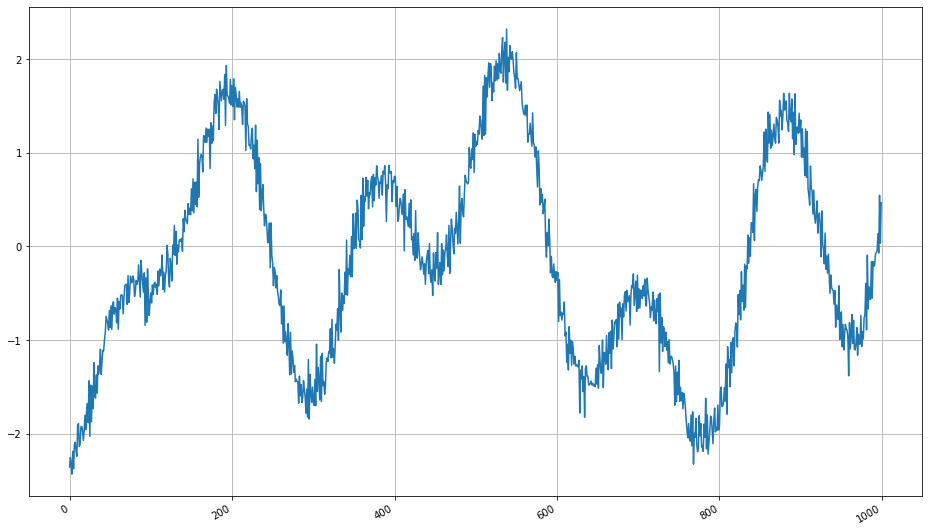

In [55]:
# Создаем набор данных
p = 2
amass = [0, -0.6, 0.04]
sigma = 0.1
hn = [0,0]
n = 1000
rank = 10
ar_seq = AR_get_sequence(p,amass,hn,sigma,n)
ar_seq = add_trend(ar_seq,'value', rank=rank)

seq = [i for i in range(n)]

test_synthetic = np.sin(np.linspace(-p*3*np.pi,p*3*np.pi,n)) + whiteNoise(sigma=0.1,size=n)

ar_seq.value += test_synthetic

#calculate equation for trendline
z = np.polyfit (seq, ar_seq.value, rank )
p = np.poly1d (z)

plt.figure(figsize=(16,10))
plt.plot(seq, ar_seq.value)

plt.gcf().autofmt_xdate()

plt.grid()

In [56]:
values = ar_seq.values[:,0]

In [57]:
# Разбиваем на окна
step = 1
len_w = 15 # размер окна предсказываемого набора
len_w_future = 15 # размер окна набора, на котором предсказывается

windows_real, windows_future_real = split_on_windows(values,len_w,len_w_future,step=step)

In [58]:
windows_future_real_train, windows_future_real_test = train_test_split(windows_future_real, test_size=0.33, shuffle=False) 

In [59]:
# Получаем классы
gc_real = GetClasses(method='growth')
gc_real_classes = gc_real.get_classes(windows_future_real_train, windows_future_real_test)

tc_real = GetClasses(method='type')
tc_real_classes = tc_real.get_classes(windows_future_real_train, windows_future_real_test)

scores_real = pd.DataFrame(['Trend Classification',
                            'Time Series Forest',
                            'Time Series Bag-of-Features',
                            'Support Vector Machines (rbf)',
                            'Support Vector Machines (linear)',
                            'Support Vector Machines (poly)', 
                            'Stochastic Gradient Descent (log_loss)',
                            'Stochastic Gradient Descent (squared_hinge)'
                            ],
                           columns=['Классификатор'])

#### Метод разделения growth

In [60]:
# Грубая выборка
scores_real['Грубые признаки (степень изменения)'] = get_scores(windows_real,gc_real_classes,method=None,random_state=random_state)

# Среднее значение, стандартное отклонение, наклон выборка
scores_real['Признаки среднее, отклонение, наклон (степень изменения)'] = get_scores(windows_real,gc_real_classes,method='mean_std_slope',random_state=random_state)

# ROCKET выборка
scores_real['Признаки ROCKET (степень изменения)'] = get_scores(windows_real,gc_real_classes,method='rocket',random_state=random_state)

#### Метод разделения type

In [61]:
# Грубая выборка
scores_real['Грубые признаки (направление)'] = get_scores(windows_real,tc_real_classes,method=None,random_state=random_state)

# Среднее значение, стандартное отклонение, наклон выборка
scores_real['Признаки среднее, отклонение, наклон (направление)'] = get_scores(windows_real,tc_real_classes,method='mean_std_slope',random_state=random_state)

# ROCKET выборка
scores_real['Признаки ROCKET (направление)'] = get_scores(windows_real,tc_real_classes,method='rocket',random_state=random_state)

In [62]:
scores_real

,Классификатор,Грубые признаки (степень изменения),"Признаки среднее, отклонение, наклон (степень изменения)",Признаки ROCKET (степень изменения),Грубые признаки (направление),"Признаки среднее, отклонение, наклон (направление)",Признаки ROCKET (направление)
0,Trend Classification,0.439252,0.510903,0.560748,0.545171,0.679128,0.679128
1,Time Series Forest,0.451713,NaN,NaN,0.616822,NaN,NaN
2,Time Series Bag-of-Features,0.429907,NaN,NaN,0.582555,NaN,NaN
3,Support Vector Machines (rbf),0.520249,0.442368,0.554517,0.629283,0.482866,0.657321
4,Support Vector Machines (linear),0.342679,0.563863,0.454829,0.638629,0.498442,0.613707
5,Support Vector Machines (poly),0.411215,0.361371,0.576324,0.542056,0.414330,0.666667
6,Stochastic Gradient Descent (log_loss),0.336449,0.408100,0.408100,0.619938,0.439252,0.707165
7,Stochastic Gradient Descent (squared_hinge),0.323988,0.392523,0.433022,0.632399,0.566978,0.582555


#### Матрица ошибок

In [63]:
X_train, X_test, y_train, y_test = train_test_split(windows_real, gc_real_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [64]:
# growth None
tc = TrendClassification(features=None,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[67  6 41]
 [46  3 34]
 [40 13 71]]


In [65]:
# growth mss
tc = TrendClassification(features=features_mss,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[60 23 31]
 [29 19 35]
 [17 22 85]]


In [66]:
# growth rocket
tc = TrendClassification(features=features_rocket,random_state=random_state, n_kernels=10000)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[74 27 13]
 [33 12 38]
 [16 22 86]]


In [67]:
X_train, X_test, y_train, y_test = train_test_split(windows_real, tc_real_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [68]:
# type None
tc = TrendClassification(features=None,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[61 52  0]
 [18 44 41]
 [ 0 35 70]]


In [69]:
# type mss
tc = TrendClassification(features=features_mss,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[71 42  0]
 [ 8 57 38]
 [ 0 15 90]]


In [70]:
# type rocket
tc = TrendClassification(features=features_rocket,random_state=random_state, n_kernels=10000)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[71 42  0]
 [15 48 40]
 [ 0  7 98]]


### EUR/USD

In [71]:
def convert_cost(x):
    res = int(x[:-5])
    res += int(x[-4:])/10000
    return res

In [72]:
eur_usd_main = pd.read_csv('datasets\EUR_USD.csv')

In [73]:
eur_usd_main['Дата'] = pd.to_datetime(eur_usd_main['Дата'],format='%d.%m.%Y')
eur_usd_main['Цена'] = eur_usd_main['Цена'].apply(convert_cost)

In [74]:
eur_usd_main

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
0,2023-06-08,1.0779,"1,0707","1,0787","1,0701",NaN,"0,67%"
1,2023-06-07,1.0707,"1,0699","1,0739","1,0669",NaN,"0,15%"
2,2023-06-06,1.0691,"1,0714","1,0733","1,0667",NaN,"-0,20%"
3,2023-06-05,1.0712,"1,0712","1,0724","1,0674",NaN,"0,06%"
4,2023-06-02,1.0706,"1,0762","1,0780","1,0704",NaN,"-0,51%"
...,...,...,...,...,...,...,...
3500,2010-01-07,1.4318,"1,4407","1,4447","1,4295",NaN,"-0,66%"
3501,2010-01-06,1.4413,"1,4364","1,4436","1,4282",NaN,"0,31%"
3502,2010-01-05,1.4369,"1,4409","1,4484","1,4346",NaN,"-0,31%"
3503,2010-01-04,1.4413,"1,4325","1,4457","1,4257",NaN,"0,61%"


In [75]:
eur_usd = eur_usd_main[['Дата','Цена']]

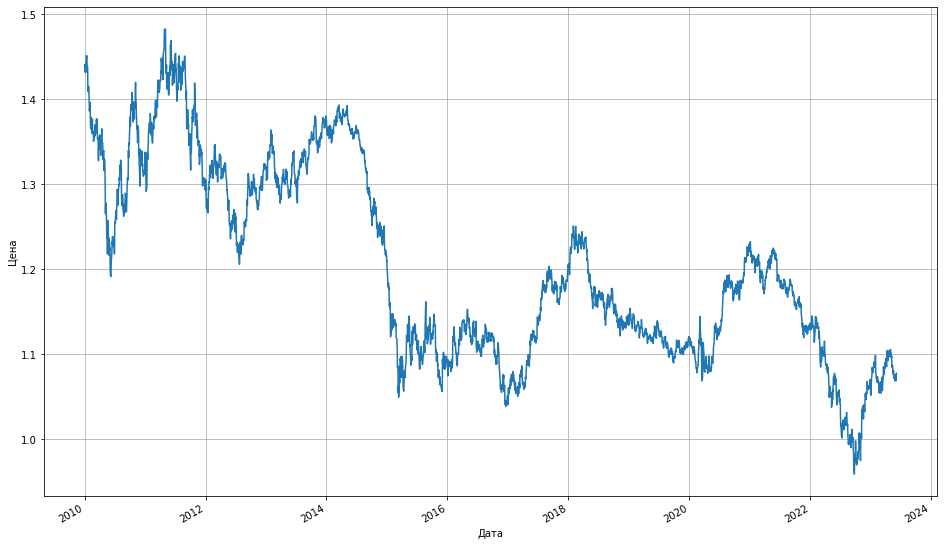

In [76]:
plt.figure(figsize=(16,10))
plt.plot(eur_usd['Дата'], eur_usd['Цена'])
plt.gcf().autofmt_xdate()
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid()

In [77]:
cost = eur_usd['Цена']

In [78]:
# Разбиваем на окна
step = 1
len_w = 15 # размер окна предсказываемого набора
len_w_future = 15 # размер окна набора, на котором предсказывается

windows_cost, windows_future_cost = split_on_windows(cost,len_w,len_w_future,step=step)
windows_future_cost_train, windows_future_cost_test = train_test_split(windows_future_cost, test_size=0.33, shuffle=False) 

In [79]:
# Получаем классы
gc_cost = GetClasses(method='growth',percent=25)
gc_cost_classes = gc_cost.get_classes(windows_future_cost_train, windows_future_cost_test)

tc_cost = GetClasses(method='type')
tc_cost_classes = tc_cost.get_classes(windows_future_cost_train, windows_future_cost_test)

scores_eur_usd = pd.DataFrame(['Trend Classification',
                                'Time Series Forest',
                                'Time Series Bag-of-Features',
                                'Support Vector Machines (rbf)',
                                'Support Vector Machines (linear)',
                                'Support Vector Machines (poly)', 
                                'Stochastic Gradient Descent (log_loss)',
                                'Stochastic Gradient Descent (squared_hinge)',
                                ],
                               columns=['Классификатор'])

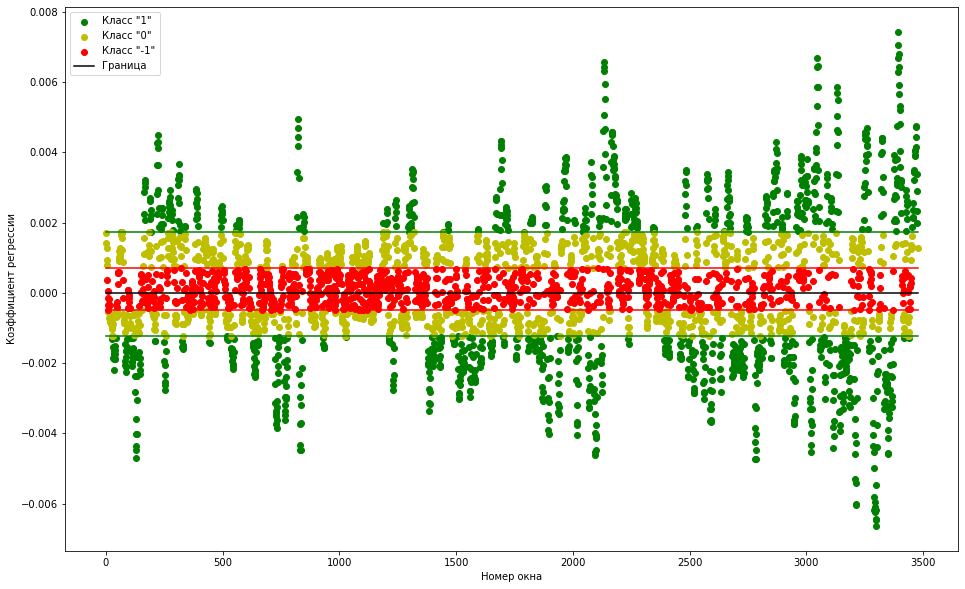

In [80]:
gc_cost.plot()

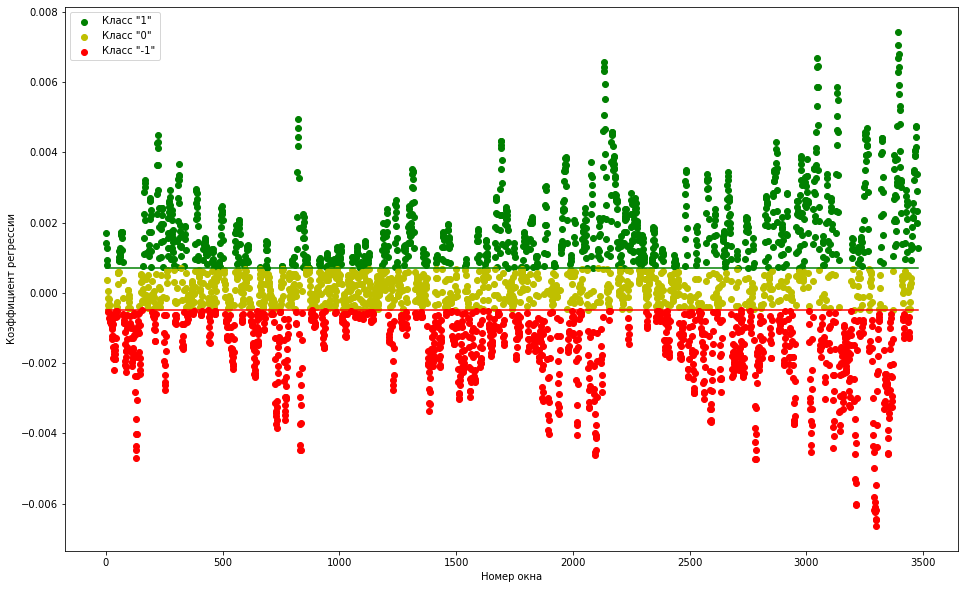

In [81]:
tc_cost.plot()

#### Метод разделения growth

In [82]:
# Грубая выборка
scores_eur_usd['Грубые признаки (степень изменения)'] = get_scores(windows_cost,gc_cost_classes,method=None,random_state=random_state)

# Среднее значение, стандартное отклонение, наклон выборка
scores_eur_usd['Признаки среднее, отклонение, наклон (степень изменения)'] = get_scores(windows_cost,gc_cost_classes,method='mean_std_slope',random_state=random_state)

# ROCKET выборка
scores_eur_usd['Признаки ROCKET (степень изменения)'] = get_scores(windows_cost,gc_cost_classes,method='rocket',random_state=random_state)

#### Метод разделения type

In [83]:
# Грубая выборка
scores_eur_usd['Грубые признаки (направление)'] = get_scores(windows_cost,tc_cost_classes,method=None,random_state=random_state)

# Среднее значение, стандартное отклонение, наклон выборка
scores_eur_usd['Признаки среднее, отклонение, наклон (направление)'] = get_scores(windows_cost,tc_cost_classes,method='mean_std_slope',random_state=random_state)

# ROCKET выборка
scores_eur_usd['Признаки ROCKET (направление)'] = get_scores(windows_cost,tc_cost_classes,method='rocket',random_state=random_state)

In [84]:
scores_eur_usd

,Классификатор,Грубые признаки (степень изменения),"Признаки среднее, отклонение, наклон (степень изменения)",Признаки ROCKET (степень изменения),Грубые признаки (направление),"Признаки среднее, отклонение, наклон (направление)",Признаки ROCKET (направление)
0,Trend Classification,0.299652,0.319686,0.513066,0.305749,0.336237,0.369338
1,Time Series Forest,0.465157,NaN,NaN,0.326655,NaN,NaN
2,Time Series Bag-of-Features,0.324042,NaN,NaN,0.279617,NaN,NaN
3,Support Vector Machines (rbf),0.357143,0.274390,0.274390,0.296167,0.202962,0.202962
4,Support Vector Machines (linear),0.274390,0.274390,0.380662,0.202962,0.202962,0.321429
5,Support Vector Machines (poly),0.230836,0.274390,0.274390,0.216899,0.202962,0.202962
6,Stochastic Gradient Descent (log_loss),0.202962,0.274390,0.456446,0.202962,0.202962,0.370209
7,Stochastic Gradient Descent (squared_hinge),0.274390,0.202962,0.274390,0.202962,0.202962,0.426829


#### Матрица ошибок

In [85]:
X_train, X_test, y_train, y_test = train_test_split(windows_cost, gc_cost_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [86]:
# Схема разделения - "Степень изменения"
# Признаки не выделяем - грубые признаки
tc = TrendClassification(features=None,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[123  66  44]
 [164  86  65]
 [305 160 135]]


In [87]:
# Схема разделения - "Степень изменения"
# Признаки - среднее, отклонение, наклон
tc = TrendClassification(features=features_mss,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[147  42  44]
 [170  80  65]
 [321 139 140]]


In [88]:
# Схема разделения - "Степень изменения"
# # Признаки - rocket
tc = TrendClassification(features=features_rocket,random_state=random_state, n_kernels=10000)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[ 83  45 105]
 [102  42 171]
 [ 87  40 473]]


In [89]:
X_train, X_test, y_train, y_test = train_test_split(windows_cost, tc_cost_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [90]:
# Схема разделения - "Направление"
# Признаки не выделяем - грубые признаки
tc = TrendClassification(features=None,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))
tc.score(X_test, y_test)

[[  7 246 237]
 [  8 120 105]
 [ 29 172 224]]


0.3057491289198606

In [91]:
# Схема разделения - "Направление"
# Признаки - среднее, отклонение, наклон
tc = TrendClassification(features=features_mss,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))
tc.score(X_test, y_test)

[[ 12 150 328]
 [  3  91 139]
 [ 23 119 283]]


0.3362369337979094

In [92]:
# Схема разделения - "Направление"
# # Признаки - rocket
tc = TrendClassification(features=features_rocket,random_state=random_state, n_kernels=1000)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))
tc.score(X_test, y_test)

[[ 18 108 364]
 [ 14  86 133]
 [ 47  60 318]]


0.367595818815331

### Yahoo Stock Price

In [252]:
yahoo_stock = pd.read_csv('datasets\Time Series Forecasting with Yahoo Stock Price\yahoo_stock.csv')
yahoo_stock['Date'] = pd.to_datetime(yahoo_stock['Date'])
yahoo_stock.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [253]:
yahoo_stock_high = yahoo_stock[['Date','High']]

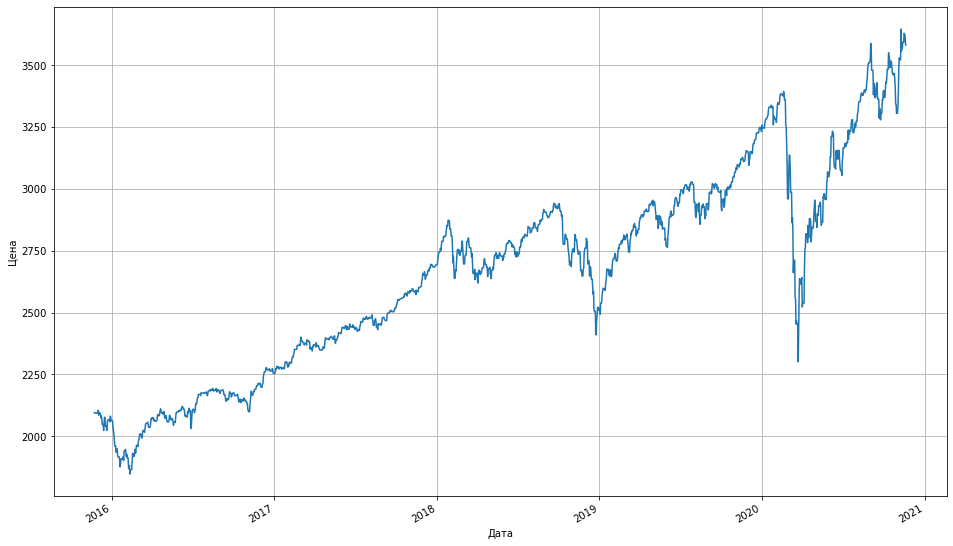

In [254]:
plt.figure(figsize=(16,10))
plt.plot(yahoo_stock_high['Date'], yahoo_stock_high['High'])
plt.gcf().autofmt_xdate()
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid()

In [255]:
high = yahoo_stock_high['High']

In [256]:
# Разбиваем на окна
step = 1
len_w = 15 # размер окна предсказываемого набора
len_w_future = 15 # размер окна набора, на котором предсказывается

windows_real, windows_future_real = split_on_windows(high,len_w,len_w_future,step=step)

In [257]:
windows_future_real_train, windows_future_real_test = train_test_split(windows_future_real, test_size=0.33, shuffle=False) 

In [258]:
# Получаем классы
gc_real = GetClasses(method='growth')
gc_real_classes = gc_real.get_classes(windows_future_real_train, windows_future_real_test)

tc_real = GetClasses(method='type')
tc_real_classes = tc_real.get_classes(windows_future_real_train, windows_future_real_test)

scores_real = pd.DataFrame(['Trend Classification',
                            'Time Series Forest',
                            'Time Series Bag-of-Features',
                            'Support Vector Machines (rbf)',
                            'Support Vector Machines (linear)',
                            'Support Vector Machines (poly)', 
                            'Stochastic Gradient Descent (log_loss)',
                            'Stochastic Gradient Descent (squared_hinge)'
                            ],
                           columns=['Классификатор'])

#### Метод разделения growth

In [259]:
# Грубая выборка
scores_real['Грубые (степень изменения)'] = get_scores(windows_real,gc_real_classes,method=None,random_state=random_state)

# Среднее значение, стандартное отклонение, наклон выборка
scores_real['Среднее, отклонение, наклон (степень изменения)'] = get_scores(windows_real,gc_real_classes,method='mean_std_slope',random_state=random_state)

# ROCKET выборка
scores_real['ROCKET (степень изменения)'] = get_scores(windows_real,gc_real_classes,method='rocket',random_state=random_state)

#### Метод разделения type

In [260]:
# Грубая выборка
scores_real['Грубые (направление)'] = get_scores(windows_real,tc_real_classes,method=None,random_state=random_state)

# Среднее значение, стандартное отклонение, наклон выборка
scores_real['Среднее, отклонение, наклон (направление)'] = get_scores(windows_real,tc_real_classes,method='mean_std_slope',random_state=random_state)

# ROCKET выборка
scores_real['ROCKET (направление)'] = get_scores(windows_real,tc_real_classes,method='rocket',random_state=random_state)

In [261]:
scores_real

,Классификатор,Грубые (степень изменения),"Среднее, отклонение, наклон (степень изменения)",ROCKET (степень изменения),Грубые (направление),"Среднее, отклонение, наклон (направление)",ROCKET (направление)
0,Trend Classification,0.283305,0.382799,0.389545,0.330523,0.254637,0.268128
1,Time Series Forest,0.347386,NaN,NaN,0.274874,NaN,NaN
2,Time Series Bag-of-Features,0.284992,NaN,NaN,0.268128,NaN,NaN
3,Support Vector Machines (rbf),0.569983,0.569983,0.569983,0.350759,0.276560,0.276560
4,Support Vector Machines (linear),0.588533,0.583474,0.499157,0.376054,0.462057,0.377740
5,Support Vector Machines (poly),0.571669,0.569983,0.569983,0.362563,0.276560,0.276560
6,Stochastic Gradient Descent (log_loss),0.569983,0.569983,0.569983,0.276560,0.276560,0.527825
7,Stochastic Gradient Descent (squared_hinge),0.258010,0.188870,0.569983,0.527825,0.276560,0.276560


#### Матрица ошибок

In [291]:
X_train, X_test, y_train, y_test = train_test_split(windows_real, gc_real_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [292]:
# growth None
tc = TrendClassification(features=None,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[ 81 233  24]
 [ 28  77   7]
 [ 20 113  10]]


In [263]:
# growth mss
tc = TrendClassification(features=features_mss,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[146 100  92]
 [ 40  39  33]
 [ 42  59  42]]


In [264]:
# growth rocket
tc = TrendClassification(features=features_rocket,random_state=random_state, n_kernels=10000)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[188 102  48]
 [ 55  47  10]
 [ 49  64  30]]


In [293]:
X_train, X_test, y_train, y_test = train_test_split(windows_real, tc_real_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [294]:
# type None
tc = TrendClassification(features=None,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[113   3   0]
 [127  31   6]
 [221  40  52]]


In [266]:
# type mss
tc = TrendClassification(features=features_mss,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

[[ 97   2  17]
 [147  10   7]
 [249  20  44]]


In [ ]:
# type mss
tc = TrendClassification(features=features_mss,random_state=random_state)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

In [ ]:
# type rocket
tc = TrendClassification(features=features_rocket,random_state=random_state, n_kernels=10000)
tc.fit(X_train,y_train)
y_pred = tc.predict(X_test)
print(confusion_matrix(y_test,y_pred))

# ---------------------------------------------------------------------------------------------------------------

# Наилучшие параметры

In [281]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report

In [249]:
# Устанавливаем параметры
random_state = 42
features_none = None
features_mss = 'mean_std_slope'
features_rocket = 'rocket'
max_depth = 3

## Искусственные данные

In [250]:
# деление на окна происходит до вызова TrendClassification
n = 1000
p = 4
seq = np.sin(np.linspace(-p*np.pi,p*np.pi,n)) + whiteNoise(sigma=0.1,size=n)

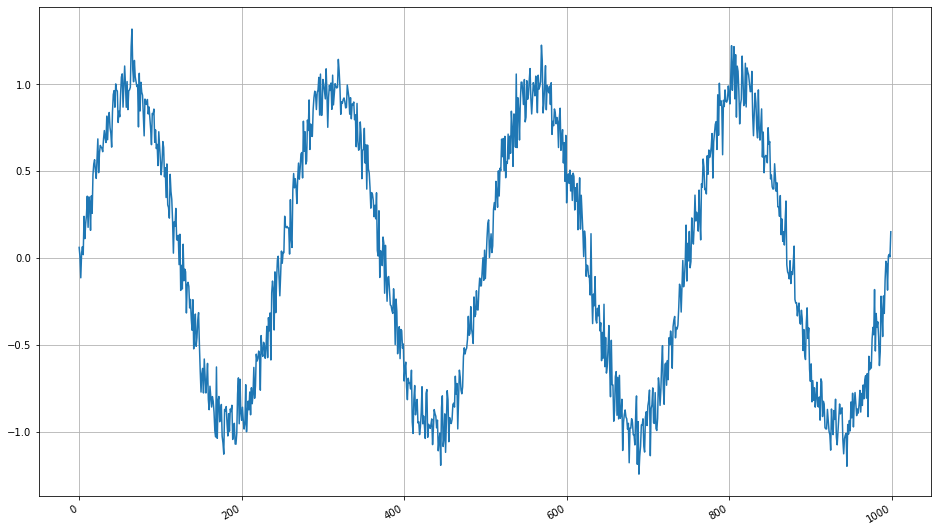

In [251]:
plt.figure(figsize=(16,10))
plt.plot(seq)
plt.gcf().autofmt_xdate()
plt.grid()

In [252]:
# Разбиваем на окна
step = 1
len_w = 15 # размер окна предсказываемого набора
len_w_future = 15 # размер окна набора, на котором предсказывается

windows, windows_future = split_on_windows(seq_main_df,len_w,len_w_future,step=step)
windows_future_train, windows_future_test = train_test_split(windows_future, test_size=0.33, shuffle=False) 

In [253]:
# Получаем классы
gc = GetClasses(method='growth')
gc_classes = gc.get_classes(windows_future_train, windows_future_test)

tc = GetClasses(method='type')
tc_classes = tc.get_classes(windows_future_train, windows_future_test)

In [285]:
# Set the parameters by cross-validation
tuned_parameters = [{
     'n_estimators': [200, 500],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
      'features' : ['mean_std_slope', 'rocket'],
    'n_kernels' : [100, 1000],
    'random_state' : [42]
    }]
tscv = TimeSeriesSplit(n_splits=2)

### growth

In [286]:
X_train, X_test, y_train, y_test = train_test_split(windows, gc_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [287]:
model = GridSearchCV(TrendClassification(), tuned_parameters, cv=tscv)
model.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
best_param_KNN = model.best_params_
print(best_param_KNN)
print()
print("Grid scores on development set:")
print()
means = model.cv_results_["mean_test_score"]
stds = model.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, model.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'criterion': 'gini', 'features': 'rocket', 'max_depth': 7, 'n_estimators': 500, 'n_kernels': 100, 'random_state': 42}

Grid scores on development set:

0.586 (+/-0.116) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}
0.586 (+/-0.116) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 1000, 'random_state': 42}
0.593 (+/-0.120) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 500, 'n_kernels': 100, 'random_state': 42}
0.593 (+/-0.120) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 500, 'n_kernels': 1000, 'random_state': 42}
0.586 (+/-0.134) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 5, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}
0.586 (+/-0.134) for {'criterion': 'gini', 'features': 'me

### type

In [288]:
X_train, X_test, y_train, y_test = train_test_split(windows, tc_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [289]:
model = GridSearchCV(TrendClassification(), tuned_parameters, cv=tscv)
model.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
best_param_KNN = model.best_params_
print(best_param_KNN)
print()
print("Grid scores on development set:")
print()
means = model.cv_results_["mean_test_score"]
stds = model.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, model.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'criterion': 'gini', 'features': 'rocket', 'max_depth': 5, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}

Grid scores on development set:

0.766 (+/-0.042) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}
0.766 (+/-0.042) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 1000, 'random_state': 42}
0.769 (+/-0.046) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 500, 'n_kernels': 100, 'random_state': 42}
0.769 (+/-0.046) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 500, 'n_kernels': 1000, 'random_state': 42}
0.750 (+/-0.028) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 5, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}
0.750 (+/-0.028) for {'criterion': 'gini', 'features': 'me

## Настоящие данные

In [290]:
yahoo_stock = pd.read_csv('datasets\Time Series Forecasting with Yahoo Stock Price\yahoo_stock.csv')
yahoo_stock['Date'] = pd.to_datetime(yahoo_stock['Date'])
yahoo_stock_high = yahoo_stock[['Date','High']]

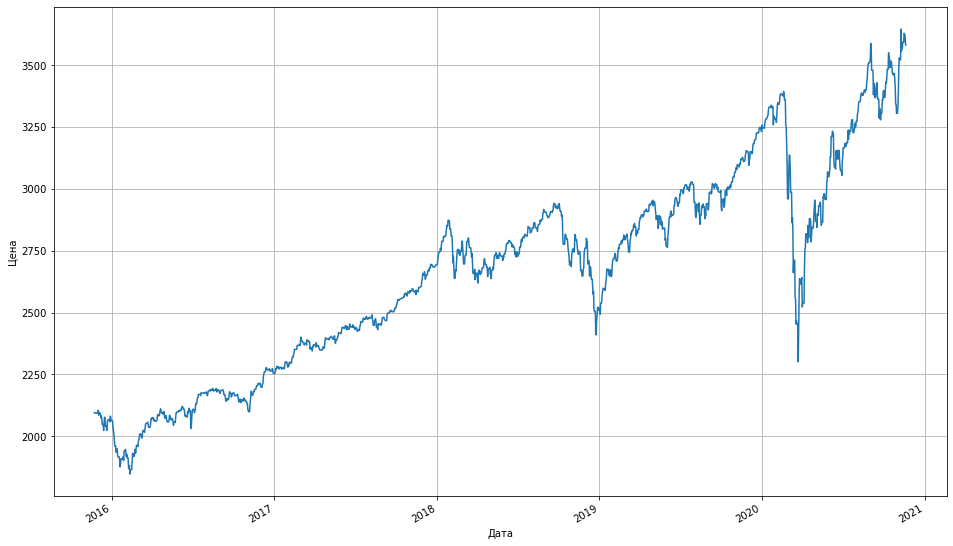

In [291]:
plt.figure(figsize=(16,10))
plt.plot(yahoo_stock_high['Date'], yahoo_stock_high['High'])
plt.gcf().autofmt_xdate()
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid()

In [292]:
high = yahoo_stock_high['High']

In [293]:
# Разбиваем на окна
step = 1
len_w = 15 # размер окна предсказываемого набора
len_w_future = 15 # размер окна набора, на котором предсказывается

windows_real, windows_future_real = split_on_windows(high,len_w,len_w_future,step=step)

In [294]:
windows_future_real_train, windows_future_real_test = train_test_split(windows_future_real, test_size=0.33, shuffle=False) 

In [295]:
# Получаем классы
gc_real = GetClasses(method='growth')
gc_real_classes = gc_real.get_classes(windows_future_real_train, windows_future_real_test)

tc_real = GetClasses(method='type')
tc_real_classes = tc_real.get_classes(windows_future_real_train, windows_future_real_test)

### growth

In [296]:
X_train, X_test, y_train, y_test = train_test_split(windows_real, gc_real_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [297]:
model = GridSearchCV(TrendClassification(), tuned_parameters, cv=tscv)
model.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
best_param_KNN = model.best_params_
print(best_param_KNN)
print()
print("Grid scores on development set:")
print()
means = model.cv_results_["mean_test_score"]
stds = model.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, model.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'criterion': 'entropy', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}

Grid scores on development set:

0.667 (+/-0.426) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}
0.667 (+/-0.426) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 1000, 'random_state': 42}
0.652 (+/-0.456) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 500, 'n_kernels': 100, 'random_state': 42}
0.652 (+/-0.456) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 500, 'n_kernels': 1000, 'random_state': 42}
0.665 (+/-0.431) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 5, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}
0.665 (+/-0.431) for {'criterion': 'gini', 'fea

### type

In [298]:
X_train, X_test, y_train, y_test = train_test_split(windows_real, tc_real_classes, test_size=0.33, shuffle=False, random_state=random_state)

In [299]:
model = GridSearchCV(TrendClassification(), tuned_parameters, cv=tscv)
model.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
best_param_KNN = model.best_params_
print(best_param_KNN)
print()
print("Grid scores on development set:")
print()
means = model.cv_results_["mean_test_score"]
stds = model.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, model.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'criterion': 'entropy', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}

Grid scores on development set:

0.519 (+/-0.249) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}
0.519 (+/-0.249) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 200, 'n_kernels': 1000, 'random_state': 42}
0.520 (+/-0.247) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 500, 'n_kernels': 100, 'random_state': 42}
0.520 (+/-0.247) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 4, 'n_estimators': 500, 'n_kernels': 1000, 'random_state': 42}
0.510 (+/-0.267) for {'criterion': 'gini', 'features': 'mean_std_slope', 'max_depth': 5, 'n_estimators': 200, 'n_kernels': 100, 'random_state': 42}
0.510 (+/-0.267) for {'criterion': 'gini', 'fea